In [3]:
import os
print(os.getcwd())


/Users/dasolyoo/Documents/workspace/tutorial/python/foodieGuide/back


In [2]:
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.agents import AgentExecutor, create_react_agent, tool

from langchain_core.runnables import Runnable
from langchain_core.messages import AIMessage, HumanMessage, AnyMessage

from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

from typing import Annotated, Dict, Optional
from typing_extensions import TypedDict

from dotenv import load_dotenv

from RAG import RAG

# 환경변수 로드 및 LLM 정의
load_dotenv()
llm = ChatOpenAI(model="gpt-4-turbo", temperature=0)

# RAG 인스턴스 준비
health_rag = RAG(RAG.HEALTH)
health_rag.load_vector_index()
ingredients_rag = RAG(RAG.INGREDIENTS)
ingredients_rag.load_vector_index()

# tool/tools 정의
@tool
def health_rag_tool(query: str) -> str:
    """의료 분야의 각 질환의 증상과 식이/생활 등의 정보를 제공합니다. 
    사용자가 자신의 건강 상태에 대해 언급한 경우 해당 도구를 사용하세요.
    건강 상태 관련 정보를 벡터 검색으로 보완하고 사용자의 건강 상태에 따라 먹어도 되는 음식의 타입, 재료 등을 확인한 후 ingredient_rag_tool을 사용해 음식을 추천하세요."""
    # 건강 상태 관련 정보를 벡터 검색으로 보완하고 사용자의 건강 상태에 따라 먹어도 되는 음식의 타입, 재료 등을 제안하세요."""
    
    prompt = health_rag.search_and_wrap(query)
    response = llm.invoke(prompt)
    result = response.content.strip() if hasattr(response, "content") else str(response)

    return result

@tool
def ingredient_rag_tool(query: str) -> str:
    """음식 메뉴에 따라 어떤 재료가 들어가는지 정보를 제공합니다. 
    사용자가 음식 메뉴를 추천받기를 원할 때 해당 도구를 사용하세요. 
    음식 재료 관련 정보를 벡터 검색으로 보완하고 메뉴를 추천하세요."""

    base_prompt = f"""
    다음 문장을 읽고 문장에 존재하는 재료로 이루어진 음식 메뉴 Top 5를 추천해줘.
    일반 음식점에서 팔지 않는 재료와 온수, 물은 제외하고, 차는 찻집으로 바꿔줘.
    고유대명사는 제외하고 일반적인 메뉴로만 대답해줘.
    문장: "{query}"
    답변 형식: 메뉴1,메뉴2,메뉴3,메뉴4,메뉴5
    """

    prompt = ingredients_rag.search_and_wrap(base_prompt)
    response = llm.invoke(prompt)
    result = response.content.strip() if hasattr(response, "content") else str(response)

    return result 

web_search_tool = TavilySearchResults(max_results=2)

tools = [health_rag_tool, ingredient_rag_tool, web_search_tool]

# prompt 정의
template = """
당신은 음식 메뉴를 추천하는 AI입니다. 
입력된 문장에서 사용자가 원하는 음식을 파악해서 메뉴를 추천하거나,
입력된 문장에서 사용자가 건강 상태를 나열할 경우 그 상태에 따라 먹어도 되는 음식 메뉴를 제안하는 AI입니다. 
입력된 문장에서 사용자가 원하는 음식을 파악하기 어려운 경우, 음식 추천을 원하지 않는 경우 일반적인 대화를 이어갈 수 있는 유연한 AI입니다. 

사용자의 질문에 단계적으로 사고하고 다음 질문에 최선을 다해 답변하세요. 당신은 다음 도구들에 접근할 수 있습니다:
{tools}

다음 형식을 사용하세요:

Question: 답변해야 하는 입력 질문
Thought: 무엇을 할지 항상 생각하세요
Action: 취해야 할 행동, [{tool_names}] 중 하나여야 합니다. 리스트에 있는 도구 중 1개를 택하십시오.
Action Input: 행동에 대한 입력값
Observation: 행동의 결과
... (이 Thought/Action/Action Input/Observation의 과정이 N번 반복될 수 있습니다)
Thought: 이제 최종 답변을 알겠습니다
Final Answer: 원래 입력된 질문에 대한 최종 답변

## 추가적인 주의사항
- 반드시 [Thought -> Action -> Action Input format] 이 사이클의 순서를 준수하십시오. 항상 Action 전에는 Thought가 먼저 나와야 합니다.
- 최종 답변에는 최대한 많은 내용을 포함하십시오.
- 한 번의 검색으로 해결되지 않을 것 같다면 문제를 분할하여 푸는 것은 중요합니다.
- 정보가 취합되었다면 불필요하게 사이클을 반복하지 마십시오.
- 묻지 않은 정보를 찾으려고 도구를 사용하지 마십시오.

시작하세요!

Question: {input}
Thought: {agent_scratchpad}"""

prompt = PromptTemplate.from_template(template)

# react_agent 정의 
react_agent = create_react_agent(llm, tools=tools, prompt=prompt)

react_agent_executor = AgentExecutor(
    agent=react_agent, tools=tools, verbose=True, handle_parsing_errors=True
)

# 📦 LangGraph 상태 정의
class GraphState(TypedDict):
    input: Annotated[list, add_messages]
    health: Optional[str] = None
    menus: Optional[str] = None
    web: Optional[str] = None
    reply: Optional[str] = None

# 🔧 ReAct Agent Node
def react_agent_node(state: GraphState) -> Dict:
    result = react_agent_executor.invoke({"input": state["input"]})
    
    # Tool 실행 결과를 파싱하여 상태에 반영
    health = None
    menus = None
    web = None

    # result는 dict, 'output' 필드에 최종 답변 있음
    if "health_rag_tool" in str(result):
        health = str(result)
    if "ingredient_rag_tool" in str(result):
        menus = str(result)
    if "TavilySearchResults" in str(result):
        web = str(result)

    return {
        "health": health,
        "menus": menus,
        "web": web,
        "reply": result["output"] if isinstance(result, dict) and "output" in result else str(result),
    }

# 💬 LLM Chat Node (결과를 재정리하거나 요약 가능)
def chat_node(state: GraphState) -> Dict:
    messages = [
        HumanMessage(content=f"""
        아래는 도구를 통해 수집된 정보야. 이걸 바탕으로 사용자에게 이해하기 쉬운 자연스러운 형태로 대답해줘.

        건강 정보: {state.health}
        추천 메뉴: {state.menus}
        웹 검색 결과: {state.web}
        """)
    ]
    response = llm.invoke(messages)
    return {"reply": response.content.strip()}

# 🌐 LangGraph 구성
graph_builder = StateGraph(GraphState)

graph_builder.add_node("react_agent_node", react_agent_node)
graph_builder.add_node("chat_node", chat_node)

# 엣지 정의
graph_builder.set_entry_point("react_agent_node")
graph_builder.add_edge("react_agent_node", "chat_node")
graph_builder.add_edge("chat_node", END)

# Graph 완성
graph = graph_builder.compile()
# print("graph", graph)
display(Image(graph.get_graph().draw_mermaid_png()))

# # 실행 예시
# inputs = {"input": "나 알레르기 때문인지 피부가 가려워"}
# final_state = graph.invoke(inputs)

# print("Final State:", final_state)


NameError: name 'Image' is not defined

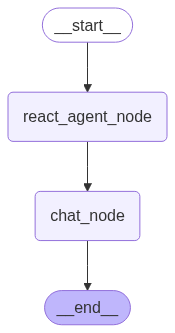

In [3]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))